# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [36]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [37]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [38]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [39]:
df_Wine.shape

(3304, 25)

In [40]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [41]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [42]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [43]:
df_GeoCache.shape

(1228, 8)

In [44]:
df_Flag.shape

(19, 3)

In [45]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
534,2015,34,2013,92.0,25,Tenet,Syrah Columbia Valley The Pundit,Red,Shiraz | Syrah,NaN,...,2017.0,2020.0,"This shows nice tension between the ripe, dark...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
432,2016,32,2014,92.0,22,Intrinsic,Cabernet Sauvignon Columbia Valley,Red,Cabernet Sauvignon,NaN,...,2018.0,2024.0,"Firm in texture, brimming with raspberry, blac...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1761,2003,60,2001,92.0,30,Columbia Crest,Syrah Columbia Valley Reserve,Red,Shiraz | Syrah,NaN,...,2003.0,2010.0,"Supple and seductive, a lush mouthful of black...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1331,2007,30,2005,92.0,25,Viña Montes,Syrah Colchagua Valley Alpha Apalta Vineyard,Red,Blend,Contains 7 percent Cabernet Sauvignon and 3 pe...,...,2007.0,2009.0,This is ripe and concentrated yet polished and...,Hierarchy_00,Chile,Chile,"(-31.7613365, -71.3187697, 0.0)",-31.761336,-71.318770,0.0
2854,1992,52,1989,93.0,22,Château Bouscaut,Pessac-Léognan,Red,Blend,Bordeaux Blend Red,...,1997.0,NaN,"The fruit jumps out of the glass, with masses ...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
1946,2001,45,1997,91.0,22,St. Supéry,Cabernet Sauvignon Napa Valley,Red,Cabernet Sauvignon,NaN,...,2002.0,2009.0,"A rich, complex and concentrated mouthful, del...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1991,2001,90,1999,93.0,23,Domaine de l'Oratoire St.-Martin,Côtes du Rhône-Villages Cairanne Cuvée Prestige,Red,Blend,Southern Rhone Red Blend,...,2001.0,2015.0,"Beautiful. Rich, ripe, thick and flavorful. Th...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
223,2018,24,2015,97.0,135,Antinori,Toscana Tignanello,Red,Blend,"Sangiovese, Cabernet Sauvignon and Cabernet Fr...",...,2021.0,2035.0,"Dense and intensely flavored, with violet, bla...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
420,2016,20,2013,94.0,48,Turley,Zinfandel Paso Robles Ueberroth Vineyard,Red,Zinfandel,NaN,...,2016.0,2028.0,"This potent red is loaded with personality, fe...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1617,2004,16,2001,95.0,85,Viña Almaviva,Puente Alto,Red,Blend,"Blend – Cabernet Sauvignon, Carmenère and Cabe...",...,2005.0,2012.0,This brick house of a wine shows plenty of Pau...,Hierarchy_00,Chile,Chile,"(-31.7613365, -71.3187697, 0.0)",-31.761336,-71.318770,0.0


## Vintage Wines were Cases Made was Non-Zero

In [46]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [47]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [48]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [49]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [95]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV')
]

df_Wine_V.shape

(3247, 25)

In [96]:
# Average Score by Wine Style - All Years
df_SWS_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_All

,Wine_Style,Avg_Score
0,Dessert & Fortified,95.318841
1,Red,93.125164
2,Rosé | Rosado,90.444444
3,Sparkling,93.586957
4,White,91.978313


In [97]:
# Average Score by Wine Style - By Review Year
df_SWS_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Score
78,2009,White,92.083333
109,2017,Dessert & Fortified,94.500000
116,2018,Sparkling,93.000000
95,2013,White,91.875000
54,2003,Red,92.485714
14,1991,White,92.814815
45,2000,Sparkling,96.000000
18,1993,Red,93.338235
29,1996,Red,92.315789
51,2002,Red,92.520548


In [98]:
# Average Score by Wine Style - All Years
df_PWS_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_All

,Wine_Style,Avg_Price
0,Dessert & Fortified,65.579712
1,Red,46.081116
2,Rosé | Rosado,24.777779
3,Sparkling,70.586960
4,White,29.065060


In [99]:
# Average Score by Wine Style - By Vintage Year
df_PWS_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Price
14,1991,White,35.000000
76,2009,Red,41.930557
82,2010,White,46.136364
28,1996,Dessert & Fortified,28.000000
33,1997,Red,39.122807
89,2012,Sparkling,54.000000
9,1990,Sparkling,34.666668
93,2013,Rosé | Rosado,28.000000
114,2018,Red,55.781250
52,2002,White,29.520000


In [100]:
# Average Score by Address - All Years
df_SA_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Address'])['Score'].mean()}).reset_index()
df_SA_All

,Address,Avg_Score
0,Argentina,91.982456
1,Australia,92.390625
2,Austria,91.571429
3,Canada,94.000000
4,Chile,92.122807
5,France,93.618490
6,Germany,92.213115
7,Greece,90.250000
8,Hungary,94.250000
9,Israel,91.000000


In [131]:
# Average Score by Address - By Review Year
df_SA_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Address'])['Score'].mean()}).reset_index()
df_SA_ByYear.sample(10)

,Review_Year,Address,Avg_Score
215,2010,Chile,90.500000
76,1998,Austria,98.000000
101,2000,USA,93.314286
251,2013,Argentina,93.000000
129,2003,Germany,93.000000
139,2004,France,93.315789
262,2013,South Africa,92.666667
100,2000,Spain,94.000000
106,2001,France,92.923077
99,2000,South Africa,92.000000


In [102]:
# Average Score by Wine Style - All Years
df_PA_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Address'])['Price'].mean()}).reset_index()
df_PA_All

,Address,Avg_Price
0,Argentina,37.473682
1,Australia,35.182293
2,Austria,25.821428
3,Canada,55.000000
4,Chile,39.385963
5,France,56.552082
6,Germany,25.852459
7,Greece,18.083334
8,Hungary,80.625000
9,Israel,37.142857


In [130]:
# Average Score by Wine Style - By Review Year
df_PA_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Address'])['Price'].mean()}).reset_index()
df_PA_ByYear.sample(10)

,Review_Year,Address,Avg_Price
151,2005,France,66.000000
279,2015,Argentina,22.000000
29,1992,France,61.902439
48,1995,Australia,33.875000
338,2019,Germany,18.500000
24,1991,Portugal,26.000000
127,2003,Chile,29.666666
157,2005,Spain,31.000000
153,2005,Italy,54.866665
257,2013,Greece,18.000000


### Visualization

In [104]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [147]:
# define a function to graph summary data

def summary_barplot(price_or_score, style_or_address):
    
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_All
        elif style_or_address == 'Address':
            df = df_PA_All
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_All
        elif style_or_address == 'Address':
            df = df_SA_All
    else:
        print('price or score')
        
    g = sns.catplot(
        data = df,
        kind = 'bar',
        y = style_or_address,
        x = 'Avg_' + price_or_score
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, 'Wine Style')
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ', 1988-2020', y = 1.1)

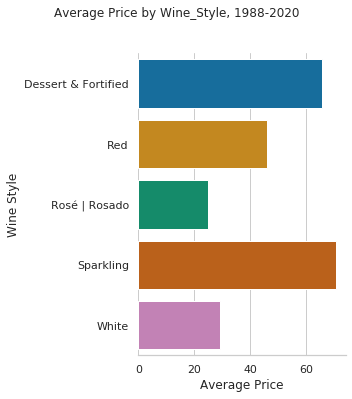

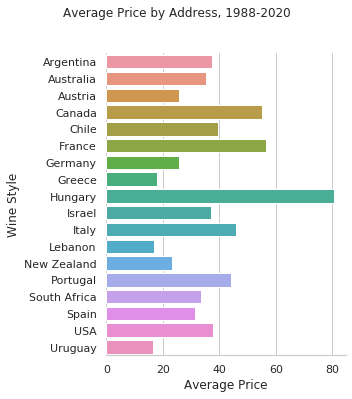

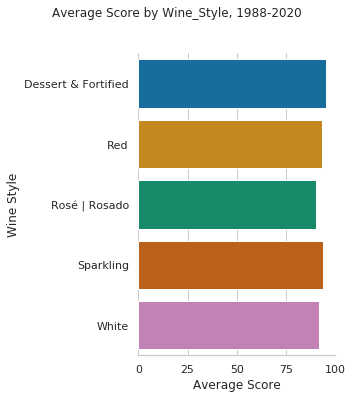

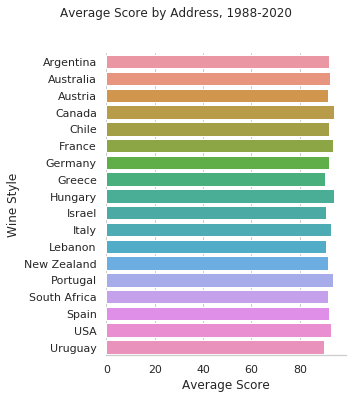

In [148]:
x_list = ['Price', 'Score']
y_list = ['Wine_Style', 'Address']

for x in x_list:
    for y in y_list:
        summary_barplot(x, y)

In [138]:
# define a function to graph summary data by Review Year

def summary_by_year_lineplot(price_or_score, style_or_address):
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_ByYear
        elif style_or_address == 'Address':
            df = df_PA_ByYear
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_ByYear
        elif style_or_address == 'Address':
            df = df_SA_ByYear
    else:
        print('price or score')
        
    g = sns.relplot(
        data = df,
        y = 'Avg_' + price_or_score,
        x = 'Review_Year',
        col = style_or_address,
        col_wrap = 3,
        kind = 'line'
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, style_or_address)
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ' by Review Year', y = 1.05)

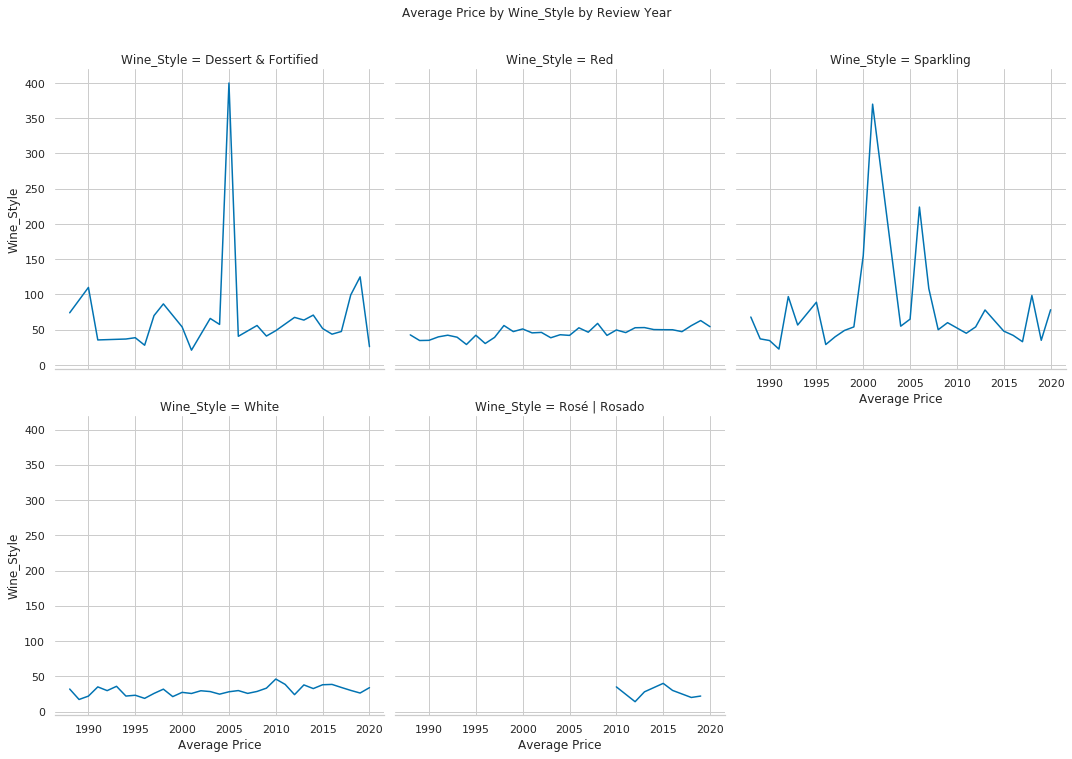

In [139]:
summary_by_year_lineplot('Price', 'Wine_Style')

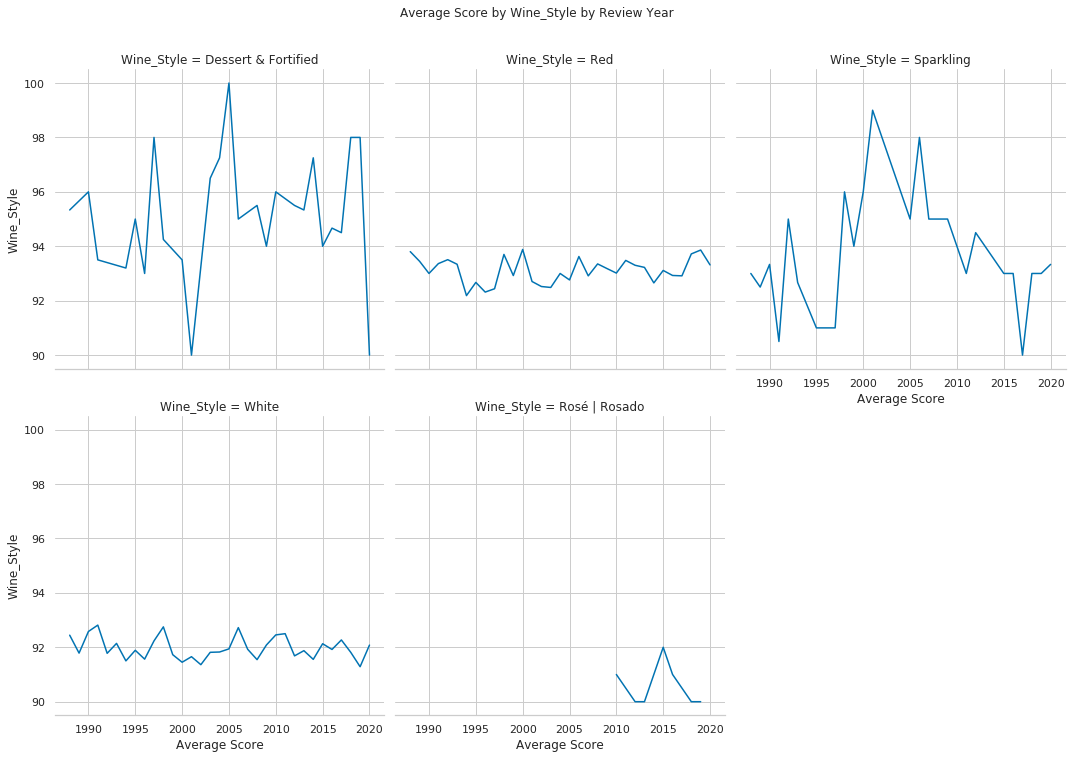

In [140]:
summary_by_year_lineplot('Score', 'Wine_Style')

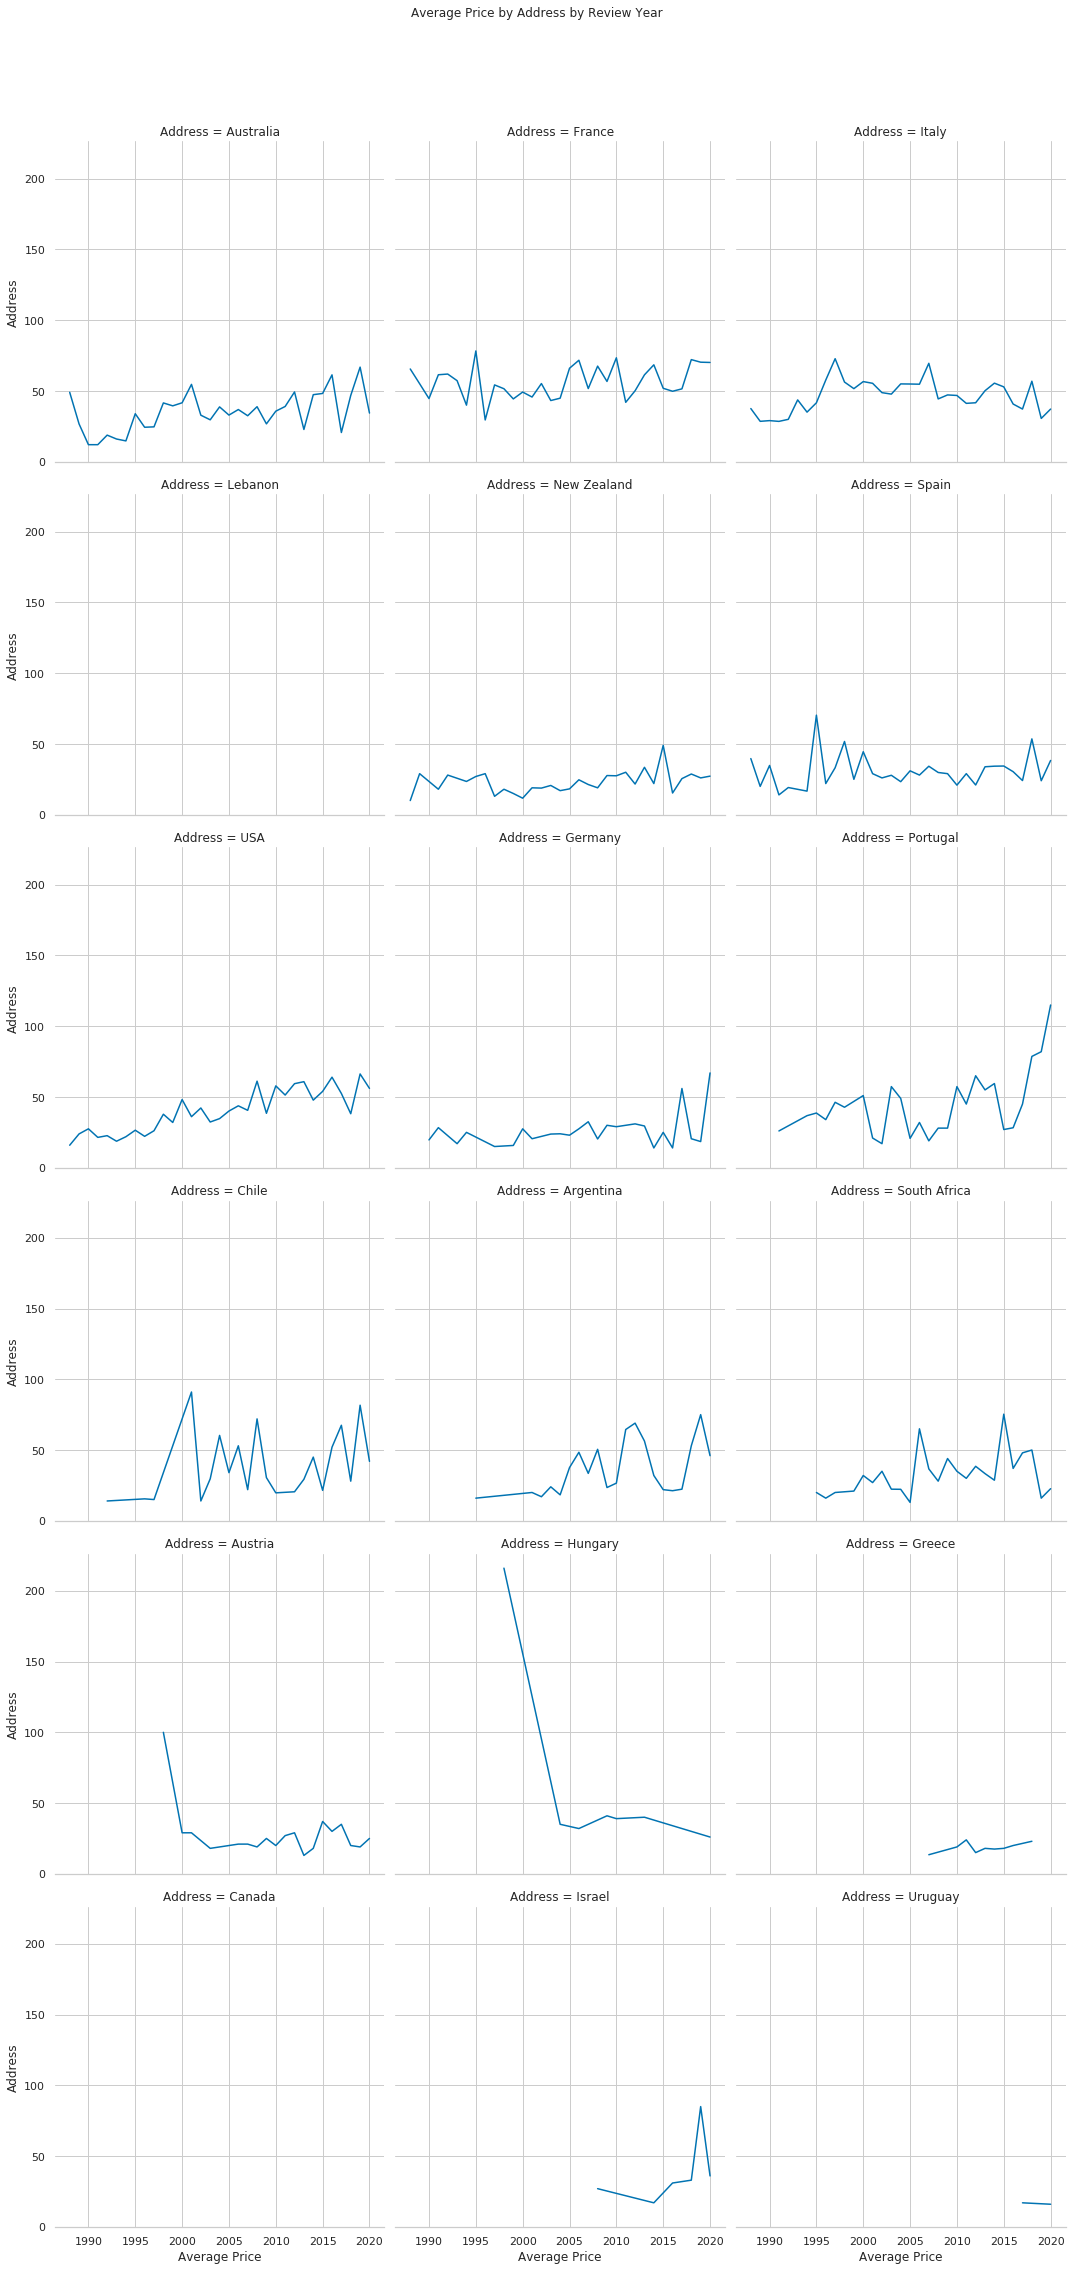

In [141]:
summary_by_year_lineplot('Price', 'Address')

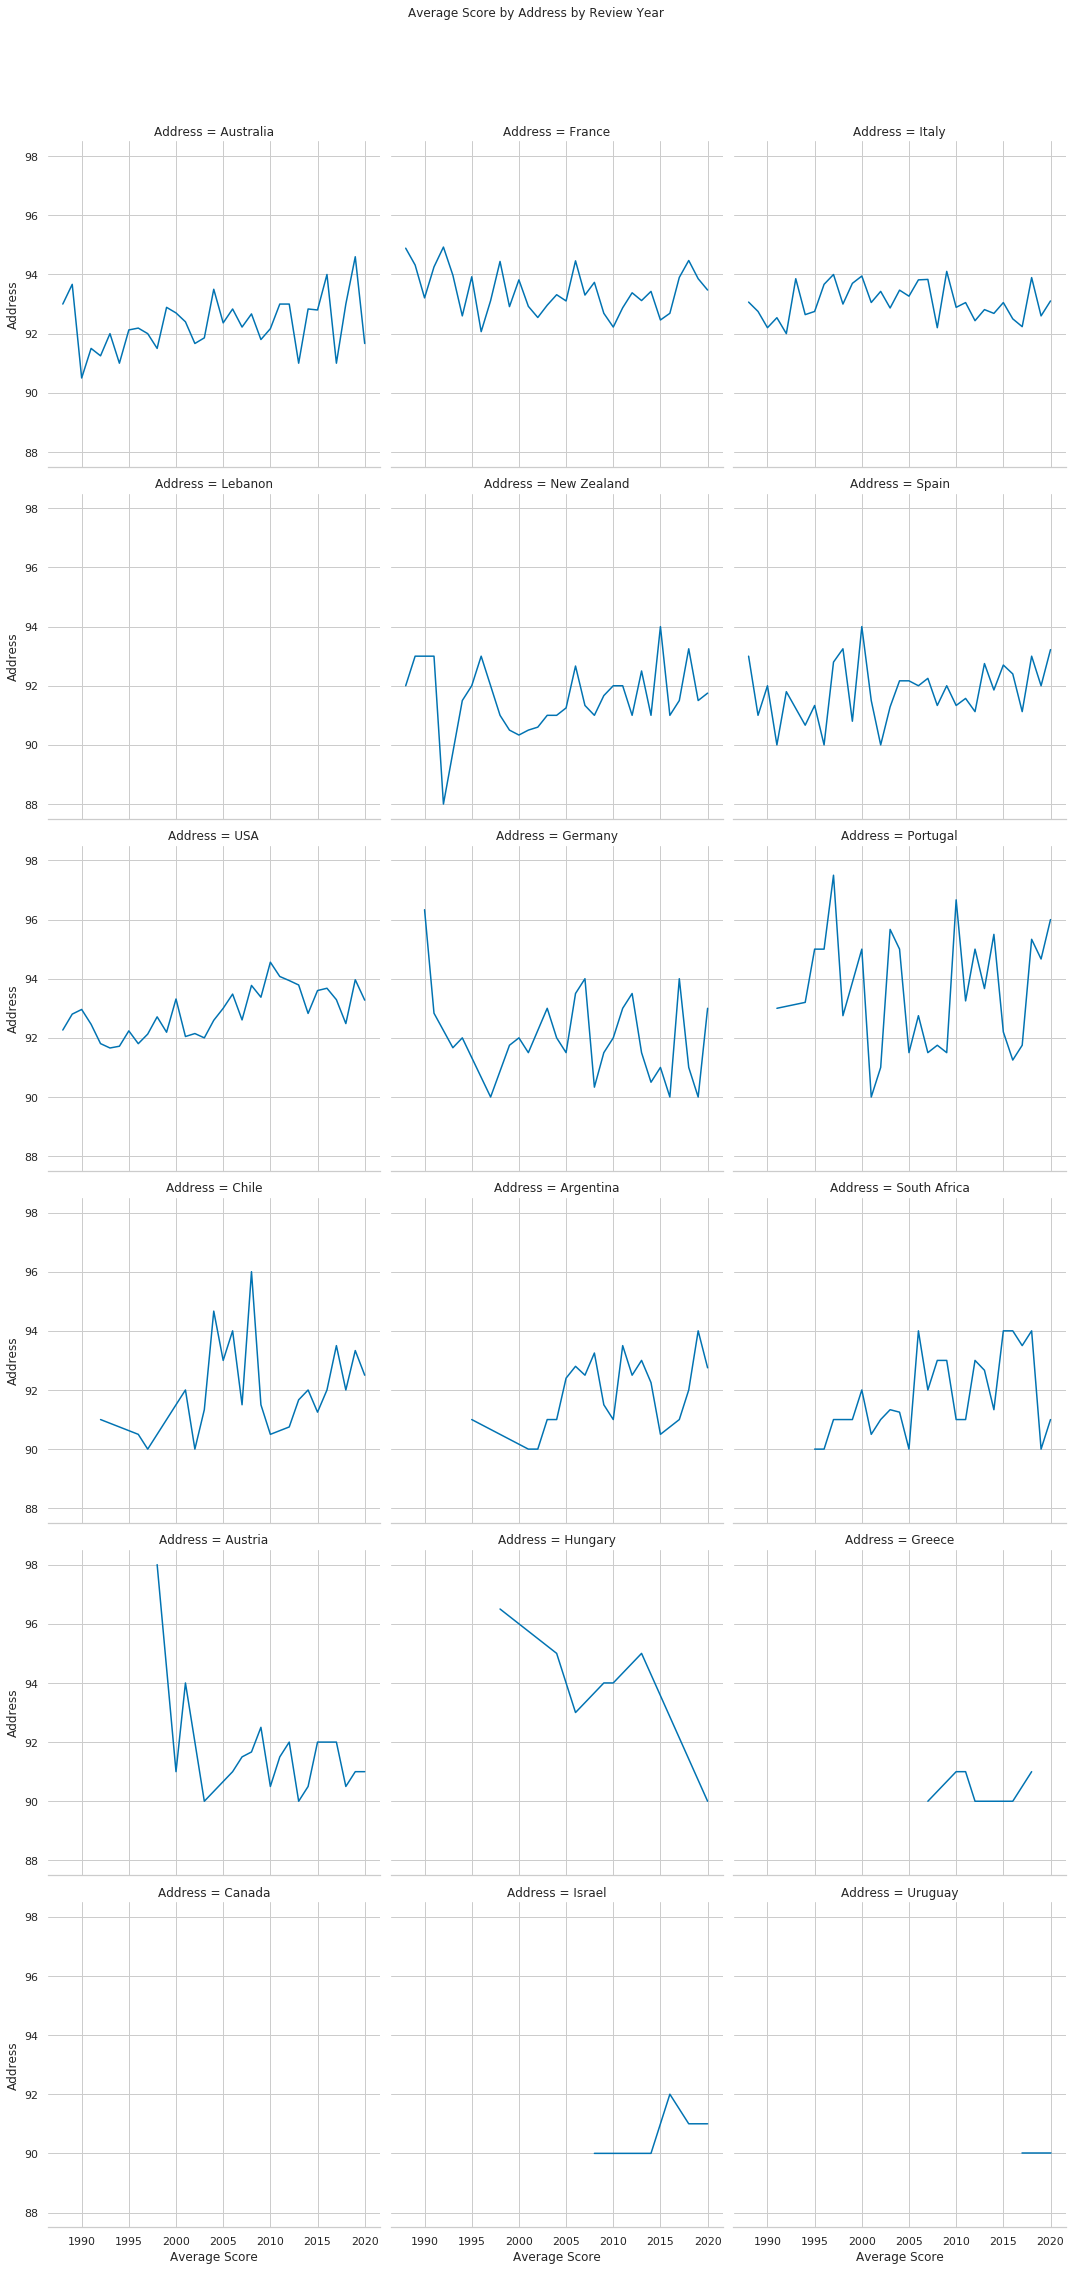

In [142]:
summary_by_year_lineplot('Score', 'Address')